In [36]:
import numpy as np
from pathlib2 import Path
from serialize import NumpyEncoder,json_numpy_obj_hook
import visualization
import random
import matplotlib.pyplot as plt
import os
from data_processing import KittiGenerator
from tqdm import tqdm
from os.path import join
import numpy as np
import matplotlib.patches as patches
import math
from matplotlib.gridspec import GridSpec
import orientation_converters as conv
import json
KITTI_DIR = "./dataset"


PRED_PATH = "preds/alpha-alpha-epoch-100-loss-0.0245-val_loss-0.2496.h5.json" #Please change this to your pred path


NUM_SECTOR = 8
NUM_BIN = 2
BATCH_SIZE = 4
NUM_WORKERS = 2

dataset = KITTI_DIR
root_path  = os.path.join(dataset,"training/")
data_label = root_path + 'label_2/'
data_img   = root_path + 'image_2/'
calib_path = root_path + "calib/"
_, fname = os.path.split(PRED_PATH )
w_text,_ = os.path.splitext(fname)
file_args = w_text.strip().split("-")
target_angle = file_args[0] #roty or alpha
orientation = file_args[1]
with open(PRED_PATH,"r+") as fp:
    all_preds = json.load(fp,object_hook=json_numpy_obj_hook)

In [39]:
instance = "000117" # change this to the specific image you wish to see

labels = []
pred_angle = []
for pred in all_preds:
    if (pred['img_id']==instance):
        labels.append(pred['line'])
        angle = pred['pred']['target_'+orientation]
        # because of code limitations, the angle must be in alpha
        if (target_angle=='rot_y'):
            tokens = pred['line'].strip().split(' ')
            angle = conv.rot_y_to_alpha(angle,float(tokens[11]),float(tokens[13]))
        pred_angle.append(angle)
    
if len(labels)==0:
    raise Exception("none found")
else:
    print(pred_angle)

[-0.0305429206923861, -1.974094706408352, -0.19580276058805518, -2.296594692695837, -2.641751605180955, 0.6495515437433212, -2.761309977907075, -1.5868551881680744]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


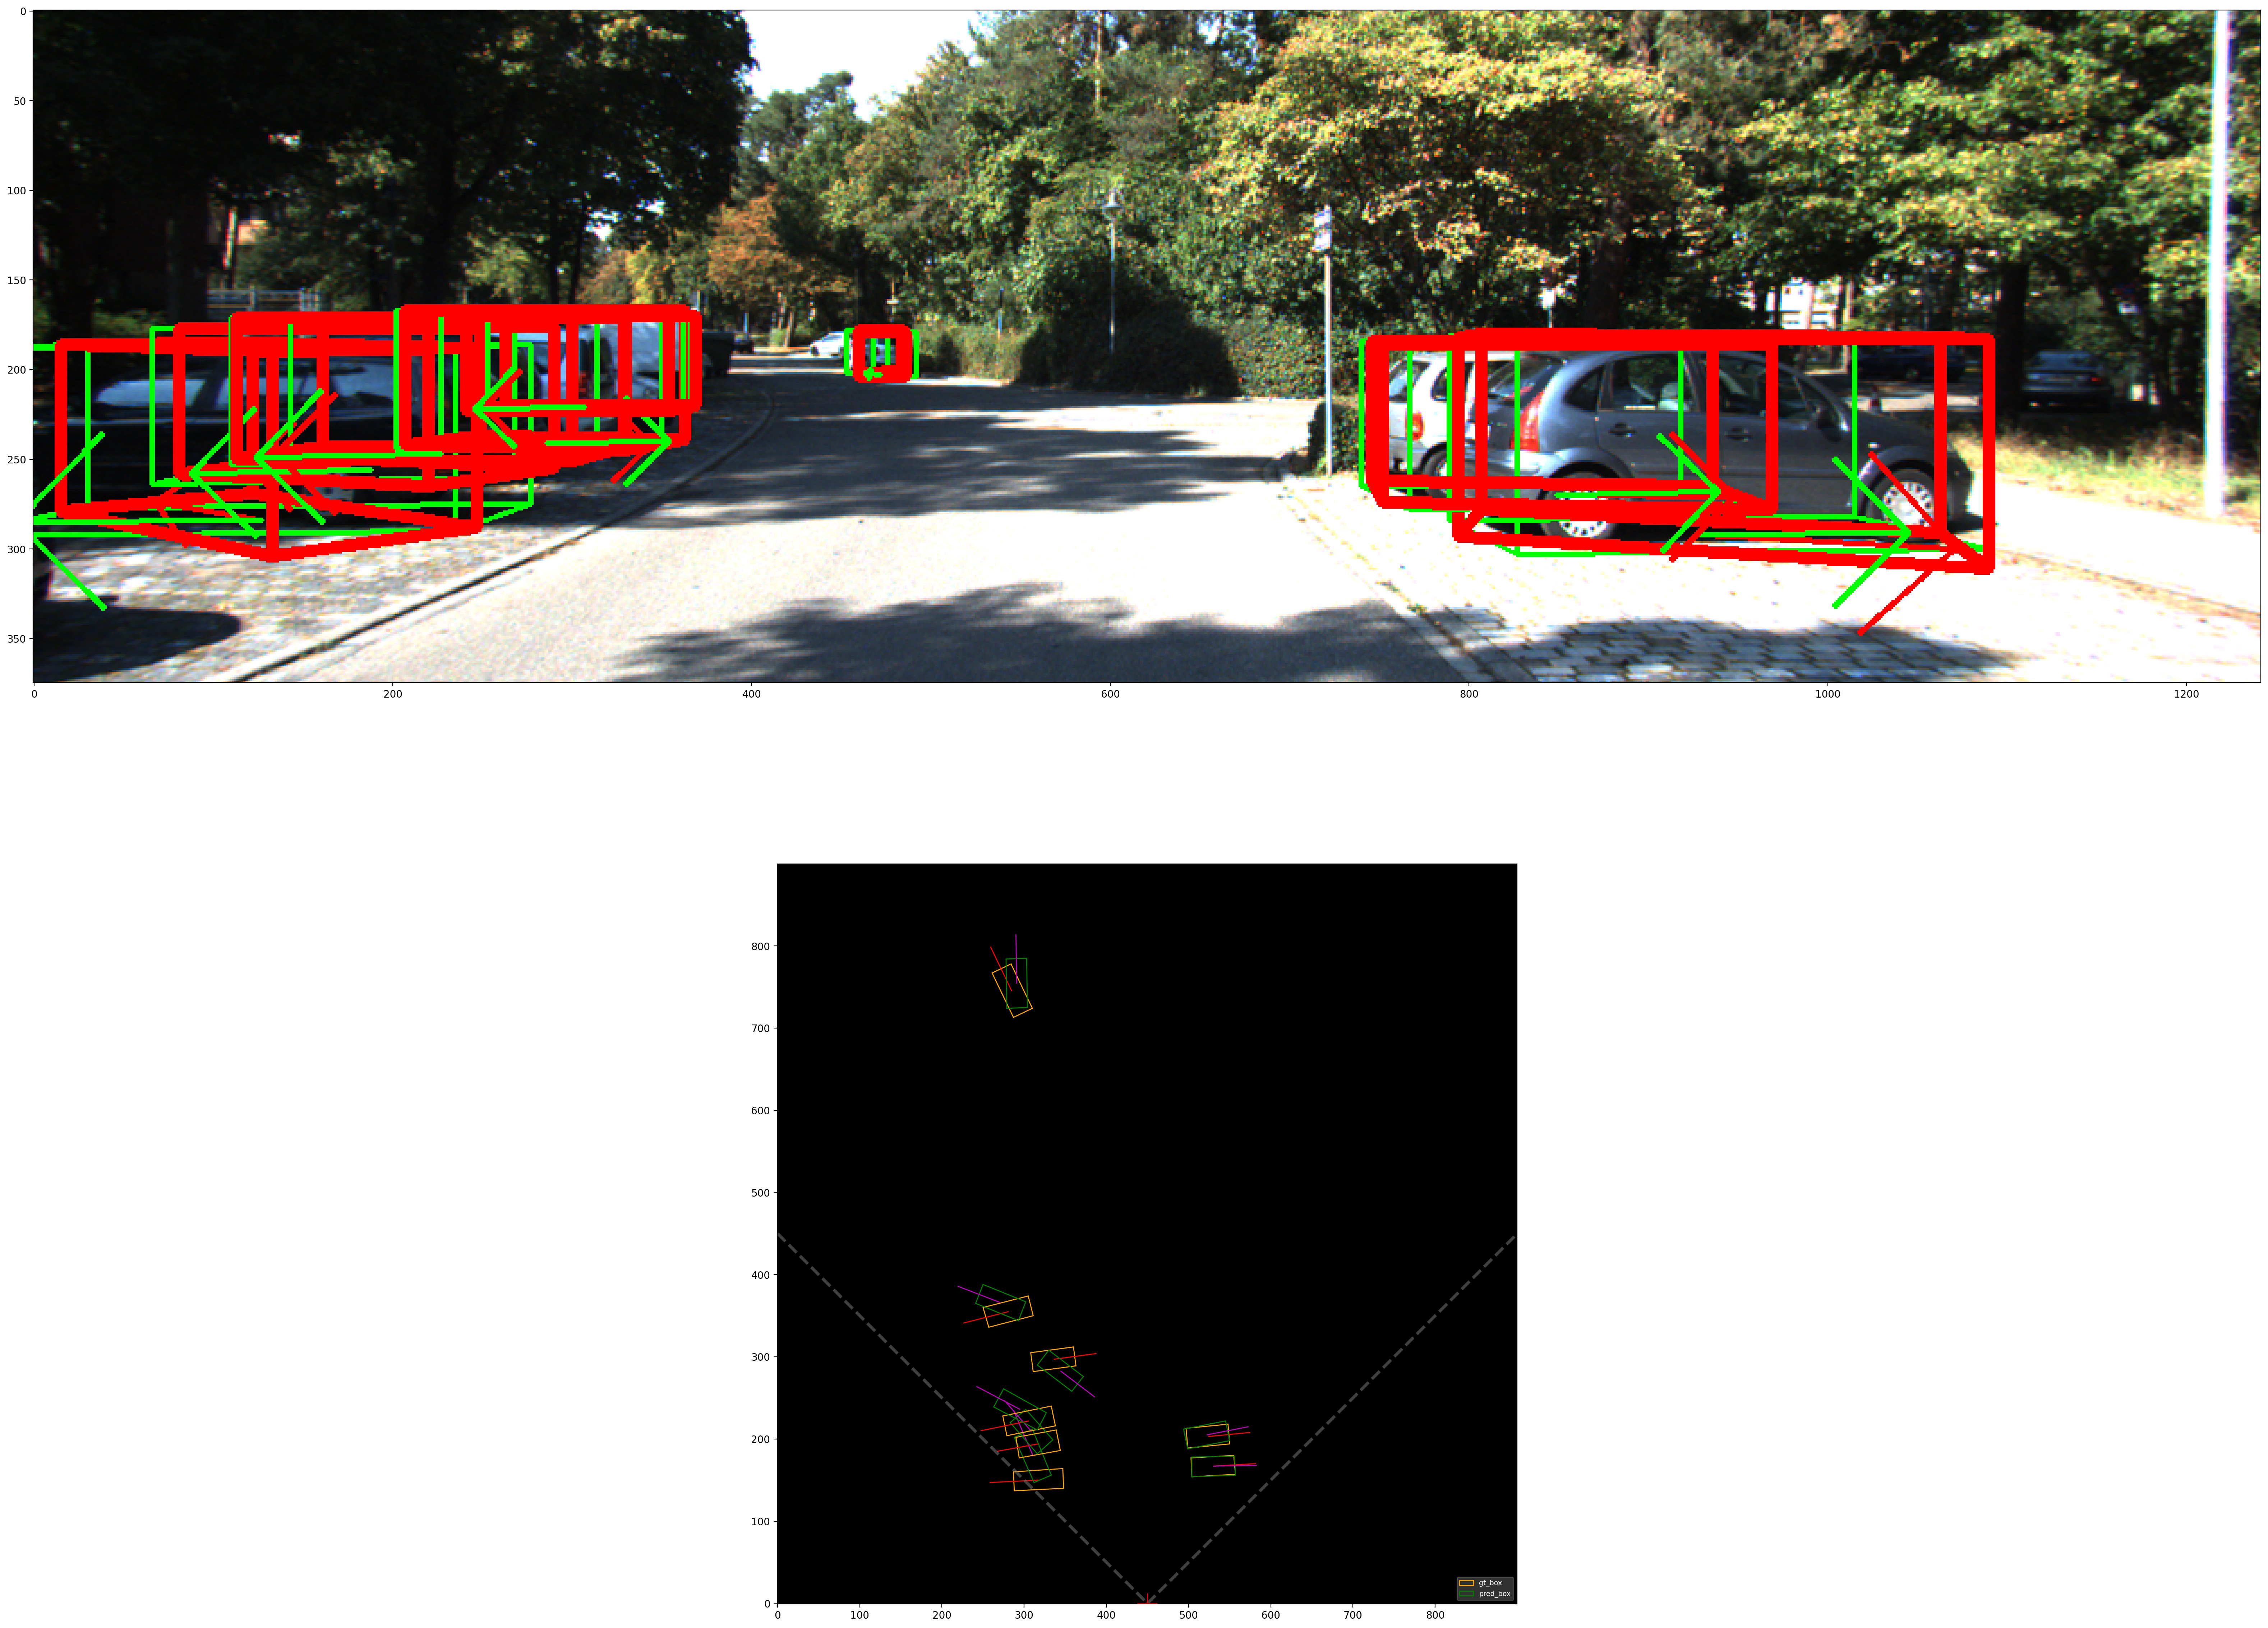

In [40]:
img_path = data_img +instance+".png"
img = plt.imread(img_path)
calib_pth = os.path.join(calib_path, instance + ".txt")
shape = 900
fig = plt.figure(figsize=(40.00, 30), dpi=200)
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


dim_pred = [np.asarray([float(x) for x in i.split(" ")[8:11]]) for i in labels]
ax.imshow(visualization.get_3d_arrow_on_img_from_batch_alpha_pred(calib_pth, [i for i in labels], img, pred_angle, dim_pred))

birdimage = np.zeros((shape, shape, 3), np.uint8)
for i,line in enumerate(labels):
    
    line_tokens = line.strip().split(' ')
    #print(line_tokens)
    pred = [x for x in line_tokens]
    pred[14] = pred_angle[i]
    visualization.draw_birdeyes(ax2, line_tokens, pred, shape)
    
x1 = np.linspace(0, shape / 2)
x2 = np.linspace(shape / 2, shape)
ax2.plot(x1, shape / 2 - x1, ls='--', color='grey', linewidth=3, alpha=0.5)
ax2.plot(x2, x2 - shape / 2, ls='--', color='grey', linewidth=3, alpha=0.5)
ax2.plot(shape / 2, 0,marker='+', markersize = 20 , markeredgecolor='red',)
handles, axlabels = ax2.get_legend_handles_labels()
legend = ax2.legend([handles[0], handles[2]], [axlabels[0], axlabels[2]], loc='lower right', fontsize='x-small', framealpha=0.2)
for text in legend.get_texts():
    plt.setp(text, color='w')



ax2.imshow(birdimage, origin='lower')


plt.show()

In [41]:
# this is a helperfunction that points out sample bad instances and images

threshold = 0.9
bad_angles = {} # print this to see what images the model failed on
completely_flipped = 0
total = 0
for pred in tqdm(all_preds):
    inst_n = pred['img_id']
    pred_angle = pred['pred']['target_'+orientation]
    line = pred['line']
    line_tokens = line.strip().split(' ')
    gt_angle= float(line_tokens[14]) if target_angle=='alpha' else float(tokens[3])
    deltas = pred_angle-gt_angle
    angle_accuracy = 0.5 * (1.0 + np.cos(deltas))
    if (angle_accuracy)<threshold:
        obj = {"instance":inst_n,"pred_angle":pred_angle,"line":line, "diff":abs(gt_angle-pred_angle)}
        if inst_n in bad_angles:
            bad_angles[inst_n].append(obj)
        else:
            bad_angles[inst_n] = [obj]
    total+=1
print("total bad angles %d"%total)


100%|████████████████████████████████████████████████████████████████████████| 26936/26936 [00:00<00:00, 325384.63it/s]

total bad angles 26936
